# Step 1 : Convert  all  spectrograms  to RGB (3 channels)

In [1]:
from PIL import Image
import os
from tqdm import tqdm

def convert_to_rgb_and_resize(folder_path):
    for root, _, files in os.walk(folder_path):
        for file in tqdm(files):
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(root, file)
                try:
                    img = Image.open(img_path).convert("RGB").resize((224, 224))
                    img.save(img_path)
                except Exception as e:
                    print(f"Error with {img_path}: {e}")

# Convert both train and val folders
convert_to_rgb_and_resize("E:/final_dataset/train")
convert_to_rgb_and_resize("E:/final_dataset/val")


0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 184/184 [00:02<00:00, 83.56it/s]
0it [00:00, ?it/s]
100%|██████████████████████████████████████████████████████████████████████████████████| 69/69 [00:00<00:00, 88.13it/s]


In [1]:
from PIL import Image
import os
import numpy as np

# Pick one sample image again
sample_path = "E:/final_dataset/train/angry"
sample_image = os.path.join(sample_path, os.listdir(sample_path)[0])
img = Image.open(sample_image)

print("Mode:", img.mode)             # Should be RGB
print("Shape:", np.array(img).shape) # Should be (224, 224, 3)
print("Size:", img.size)             # Should be (224, 224)


Mode: RGB
Shape: (224, 224, 3)
Size: (224, 224)


#  Step 2: All Imports & Configuration Setup



In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing import image_dataset_from_directory

import matplotlib.pyplot as plt
import numpy as np
import os


In [3]:
# Constants
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 7
EPOCHS = 20

# Paths
TRAIN_DIR = "E:/final_dataset/train"
VAL_DIR = "E:/final_dataset/val"
MODEL_SAVE_PATH = "E:/final_efficient_model.keras"


# Step 3: Data Loading Using image_dataset_from_directory

In [4]:
# Load training dataset
train_dataset = image_dataset_from_directory(
    TRAIN_DIR,
    labels='inferred',
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    shuffle=True,
    color_mode="rgb"
)

# Load validation dataset
val_dataset = image_dataset_from_directory(
    VAL_DIR,
    labels='inferred',
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    shuffle=False,
    color_mode="rgb"
)


Found 9469 files belonging to 7 classes.
Found 2810 files belonging to 7 classes.


In [5]:
import tensorflow as tf

# Set batch size and image size
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

# Path to training and validation directories on your E drive
train_dir = "E:/final_dataset/train"
val_dir = "E:/final_dataset/val"

# Create training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.0,  # since val_ds created separately
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int',   # sparse_categorical_crossentropy needs int labels
    shuffle=True
)

# Create validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    validation_split=0.0,
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int',
    shuffle=False
)

# Prefetch for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)


Found 9469 files belonging to 7 classes.
Found 2810 files belonging to 7 classes.


# Step 4: Build the EfficientNetB0 Model

In [7]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models

# Load the base EfficientNetB0 model without top layers
base_model = EfficientNetB0(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
base_model.trainable = False  # Freeze base initially

# Create the full model
inputs = layers.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)  # Helps prevent overfitting
outputs = layers.Dense(7, activation='softmax')(x)  # 7 classes
model = models.Model(inputs, outputs)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 7)                   │           8,967 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,058,538 (15.48 MB)

 Trainable params: 8,967 (35.03 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

#  Step 5: Callbacks (EarlyStopping, ReduceLROnPlateau, and Checkpoint saving to E:)

In [8]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Path to save best model on E: drive
checkpoint_path = "E:/final_efficient_model.keras"

callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, min_lr=1e-6, verbose=1),
    ModelCheckpoint(filepath=checkpoint_path, monitor='val_accuracy', save_best_only=True, verbose=1)
]


#  Step 6: Train the Model (initial phase - frozen base)

In [11]:
# Compile the model (frozen base)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Initial training: frozen base
history_frozen = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,  # Adjust based on observation
    callbacks=callbacks
)


Epoch 1/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1885 - loss: 1.9119
Epoch 1: val_accuracy improved from -inf to 0.35196, saving model to E:/final_efficient_model.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 531s 2s/step - accuracy: 0.1887 - loss: 1.9116 - val_accuracy: 0.3520 - val_loss: 1.7097 - learning_rate: 1.0000e-04
Epoch 2/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2947 - loss: 1.7175
Epoch 2: val_accuracy improved from 0.35196 to 0.41352, saving model to E:/final_efficient_model.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 519s 2s/step - accuracy: 0.2948 - loss: 1.7174 - val_accuracy: 0.4135 - val_loss: 1.5952 - learning_rate: 1.0000e-04
Epoch 3/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3415 - loss: 1.6270
Epoch 3: val_accuracy improved from 0.41352 to 0.46014, saving model to E:/final_efficient_model.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 476s 2s/step - accuracy: 0.3416 - loss: 1.6270 - val_accuracy: 0.4601 - val_loss: 1.5140 - learning_rate: 1.0000e-04
E

In [9]:
model.save("E:/final_efficient_model.keras")


# Step 7: Fine-Tune the Unfrozen Base Model 

In [4]:
#  Load the best model from frozen training
model = tf.keras.models.load_model("E:/final_efficient_model.keras")
model.summary()

C:\Users\ALL\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 6 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 7)                   │           8,967 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,076,474 (15.55 MB)

 Trainable params: 8,967 (35.03 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

 Optimizer params: 17,936 (70.07 KB)

In [6]:
# Step 1: Import if needed
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Step 2: Load the best model from frozen training
model = tf.keras.models.load_model("E:/final_efficient_model.keras")

# Step 3: Unfreeze top 20 layers only (efficient fine-tuning)
# EfficientNet base model is usually at index 1
base_model = model.layers[1]
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Step 4: Recompile with lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Step 5: Print trainable layer count
trainable_count = len([l for l in model.layers if l.trainable])
print(f" Trainable layers: {trainable_count} / {len(model.layers)}")

# Step 6: Redefine callbacks (if kernel was restarted)
checkpoint_cb = ModelCheckpoint("E:/final_efficient_model.keras", monitor='val_accuracy',
                                save_best_only=True, verbose=1)
earlystop_cb = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
reduce_lr_cb = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.2, verbose=1)

callbacks = [checkpoint_cb, earlystop_cb, reduce_lr_cb]

# Step 7: Fine-tune (will now be faster per epoch)
history_finetune = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks
)


 Trainable layers: 4 / 5
Epoch 1/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2183 - loss: 1.8894
Epoch 1: val_accuracy improved from -inf to 0.42491, saving model to E:/final_efficient_model.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 586s 2s/step - accuracy: 0.2185 - loss: 1.8891 - val_accuracy: 0.4249 - val_loss: 1.6264 - learning_rate: 1.0000e-05
Epoch 2/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3909 - loss: 1.6208
Epoch 2: val_accuracy improved from 0.42491 to 0.52313, saving model to E:/final_efficient_model.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 567s 2s/step - accuracy: 0.3910 - loss: 1.6207 - val_accuracy: 0.5231 - val_loss: 1.4003 - learning_rate: 1.0000e-05
Epoch 3/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4621 - loss: 1.4619
Epoch 3: val_accuracy improved from 0.52313 to 0.56655, saving model to E:/final_efficient_model.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 570s 2s/step - accuracy: 0.4621 - loss: 1.4618 - val_accuracy: 0.5665 - val_loss: 1.2615 - le

In [8]:
# Optional: Save current state of the model before continuing
model.save("E:/final_efficient_model_backup_before_next.keras")
print(" Model saved as 'final_efficient_model_backup_before_next.keras'")


 Model saved as 'final_efficient_model_backup_before_next.keras'


In [9]:
# Step 1: Imports
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# Step 2: Load best model so far
model = tf.keras.models.load_model("E:/final_efficient_model.keras")

# Step 3: Unfreeze top 30 layers of the base model (deeper fine-tuning)
base_model = model.layers[1]
for layer in base_model.layers[-30:]:
    layer.trainable = True

# Freeze BatchNorm layers (optional but helps stability)
for layer in base_model.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False

# Step 4: Recompile with standard sparse categorical loss
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# Step 5: Print trainable layer count
trainable_count = sum([1 for l in model.layers if l.trainable])
print(f" Trainable layers: {trainable_count} / {len(model.layers)}")

# Step 6: Redefine callbacks
checkpoint_cb = ModelCheckpoint("E:/final_efficient_model.keras", monitor='val_accuracy',
                                save_best_only=True, verbose=1)
earlystop_cb = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
reduce_lr_cb = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.2, verbose=1)
callbacks = [checkpoint_cb, earlystop_cb, reduce_lr_cb]

# Step 7: Fine-tune further
history_finetune = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,  # You can increase if needed
    callbacks=callbacks
)


 Trainable layers: 4 / 5
Epoch 1/15
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6125 - loss: 1.0219
Epoch 1: val_accuracy improved from -inf to 0.65160, saving model to E:/final_efficient_model.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 595s 2s/step - accuracy: 0.6126 - loss: 1.0219 - val_accuracy: 0.6516 - val_loss: 0.9139 - learning_rate: 1.0000e-05
Epoch 2/15
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 70s/step - accuracy: 0.6242 - loss: 0.9763  
Epoch 2: val_accuracy improved from 0.65160 to 0.66157, saving model to E:/final_efficient_model.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 20772s 70s/step - accuracy: 0.6242 - loss: 0.9763 - val_accuracy: 0.6616 - val_loss: 0.8950 - learning_rate: 1.0000e-05
Epoch 3/15
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6312 - loss: 0.9624
Epoch 3: val_accuracy improved from 0.66157 to 0.66512, saving model to E:/final_efficient_model.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 627s 2s/step - accuracy: 0.6312 - loss: 0.9623 - val_accuracy: 0.6651 - val_loss: 0.881

In [12]:
# Compile model with Adam optimizer and cosine-decayed LR schedule
final_model.compile(
    optimizer=Adam(learning_rate=lr_schedule),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Callbacks without ReduceLROnPlateau
checkpoint_cb = ModelCheckpoint(
    "E:/final_efficient_model.keras", save_best_only=True, monitor='val_accuracy', mode='max'
)
earlystop_cb = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# Train the model
history = final_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,
    callbacks=[checkpoint_cb, earlystop_cb]  # Removed reduce_lr_cb here
)


Epoch 1/25
296/296 ━━━━━━━━━━━━━━━━━━━━ 661s 2s/step - accuracy: 0.6423 - loss: 0.9630 - val_accuracy: 0.6762 - val_loss: 0.8604
Epoch 2/25
296/296 ━━━━━━━━━━━━━━━━━━━━ 605s 2s/step - accuracy: 0.6467 - loss: 0.9467 - val_accuracy: 0.6836 - val_loss: 0.8406
Epoch 3/25
296/296 ━━━━━━━━━━━━━━━━━━━━ 535s 2s/step - accuracy: 0.6657 - loss: 0.9162 - val_accuracy: 0.6925 - val_loss: 0.8268
Epoch 4/25
296/296 ━━━━━━━━━━━━━━━━━━━━ 521s 2s/step - accuracy: 0.6666 - loss: 0.9009 - val_accuracy: 0.6961 - val_loss: 0.8162
Epoch 5/25
296/296 ━━━━━━━━━━━━━━━━━━━━ 508s 2s/step - accuracy: 0.6695 - loss: 0.9004 - val_accuracy: 0.6989 - val_loss: 0.8085
Epoch 6/25
296/296 ━━━━━━━━━━━━━━━━━━━━ 510s 2s/step - accuracy: 0.6776 - loss: 0.8750 - val_accuracy: 0.6993 - val_loss: 0.8044
Epoch 7/25
296/296 ━━━━━━━━━━━━━━━━━━━━ 511s 2s/step - accuracy: 0.6791 - loss: 0.8772 - val_accuracy: 0.7021 - val_loss: 0.8021
Epoch 8/25
296/296 ━━━━━━━━━━━━━━━━━━━━ 509s 2s/step - accuracy: 0.6779 - loss: 0.8682 - val_accu

In [36]:
# Load your best saved model
from tensorflow.keras.models import load_model
model = load_model("E:/final_efficient_model.keras")

# Unfreeze the base model for fine-tuning
# model.layers[0].trainable = True  # EfficientNetB0 base model is the first layer
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │           8,967 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,902,074 (18.70 MB)

 Trainable params: 421,767 (1.61 MB)

 Non-trainable params: 3,636,771 (13.87 MB)

 Optimizer params: 843,536 (3.22 MB)

In [37]:
import tensorflow as tf

val_dir = "E:/final_dataset/val"
img_size = (224, 224)
batch_size = 32

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False
)

class_names = val_ds.class_names
num_classes = len(class_names)


Found 2810 files belonging to 7 classes.


# Step 8:Evaluate the Model on Validation Data

In [38]:
loss, accuracy = model.evaluate(val_ds)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy * 100:.2f}%")


88/88 ━━━━━━━━━━━━━━━━━━━━ 153s 1s/step - accuracy: 0.6927 - loss: 0.8231
Validation Loss: 0.7936
Validation Accuracy: 70.46%


# Step 9:Plot Training and Validation Accuracy and Loss Curves

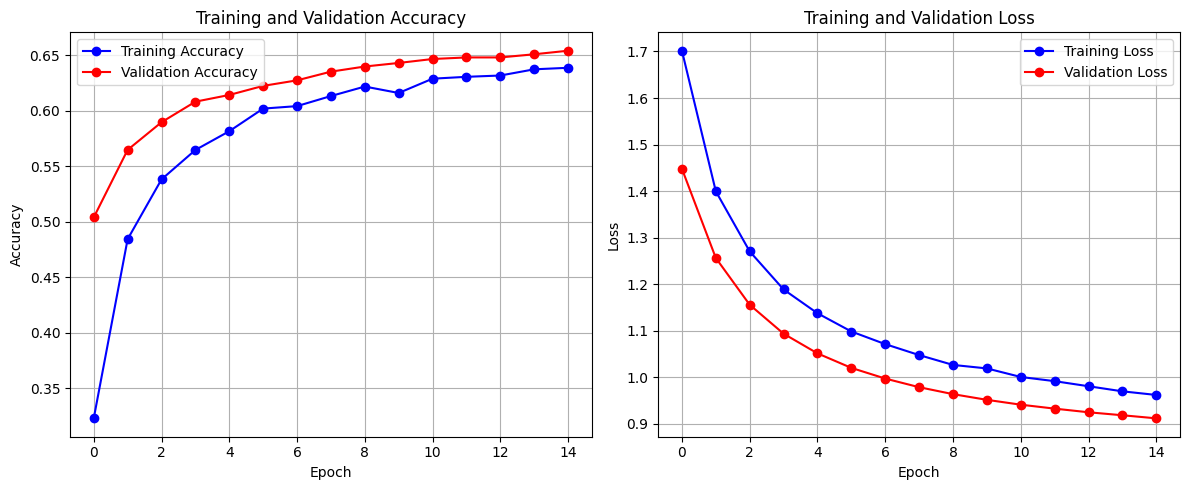

In [41]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.figure(figsize=(12, 5))
    
    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

# Call the function
plot_training_history(history)


# Step 10:Plot Precision-Recall Curves for Each Emotion Class

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

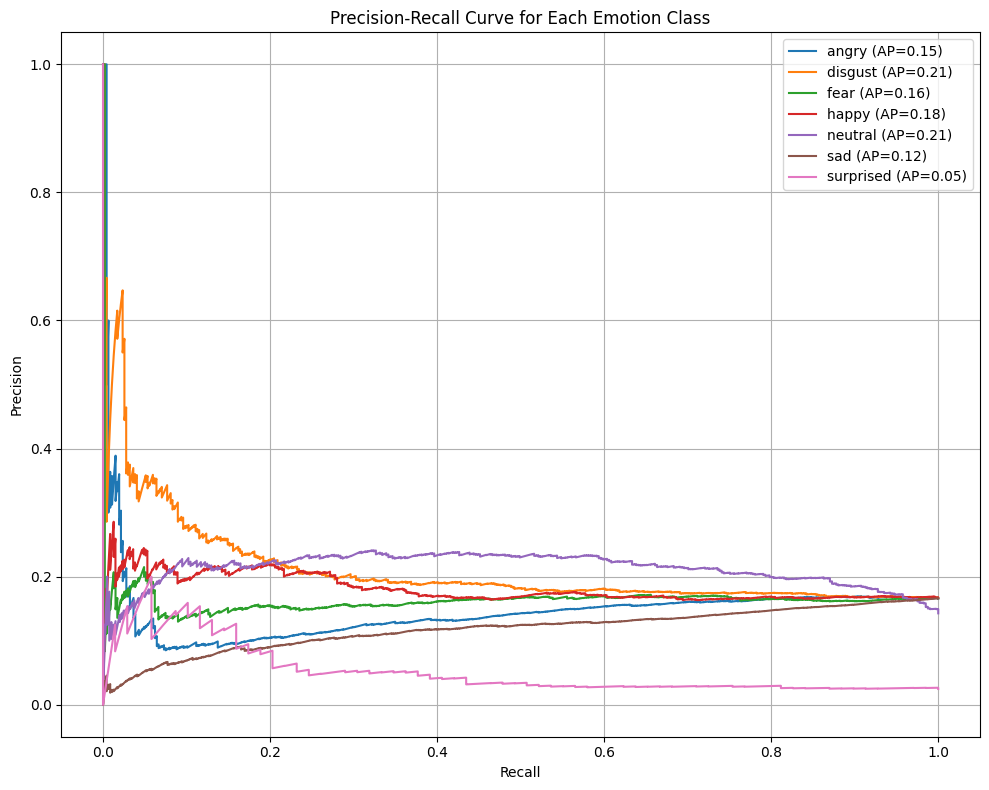

In [42]:
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Get true labels and predicted probabilities
y_true = []
y_pred_proba = []

for images, labels in val_ds:
    y_true.extend(labels.numpy())
    y_pred_proba.extend(final_model.predict(images))

y_true = np.array(y_true)
y_pred_proba = np.array(y_pred_proba)

# One-hot encode y_true
y_true_bin = label_binarize(y_true, classes=np.arange(len(class_names)))

# Plot Precision-Recall curves
plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_pred_proba[:, i])
    ap = average_precision_score(y_true_bin[:, i], y_pred_proba[:, i])
    plt.plot(recall, precision, label=f"{class_names[i]} (AP={ap:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for Each Emotion Class")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Step 11:  ROC Curves and AUC (Area Under the Curve)

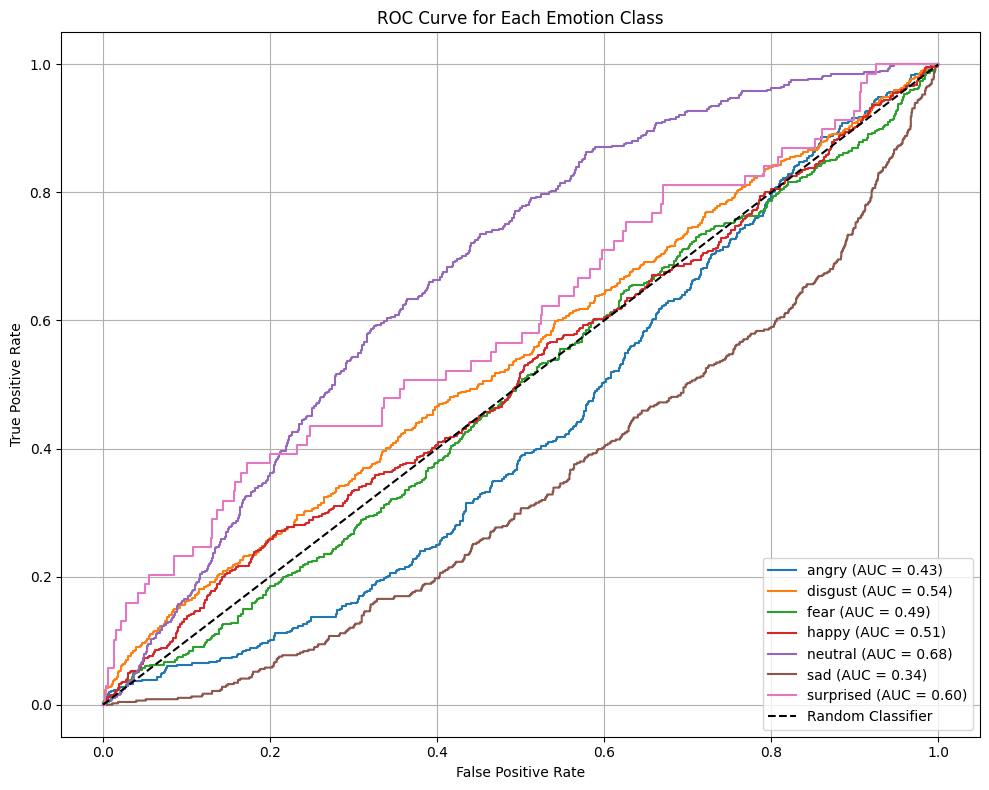

In [43]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# One-hot encode the ground truth labels (if not done already)
y_true_bin = label_binarize(y_true, classes=np.arange(len(class_names)))

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc:.2f})")

# Diagonal reference line
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Emotion Class')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


# 

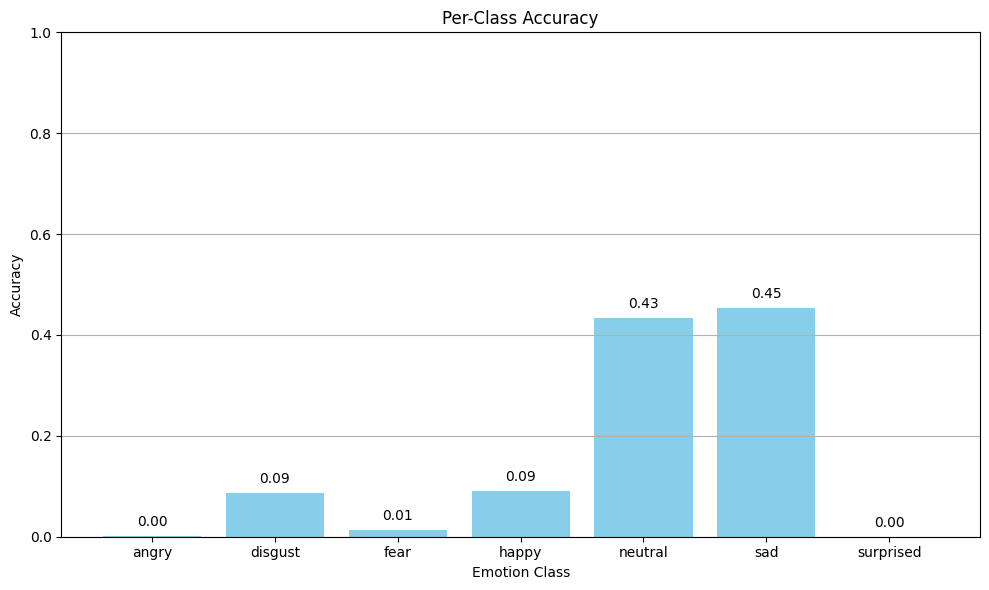

In [44]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Get predicted class indices from probability outputs
y_pred_labels = np.argmax(y_pred_proba, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_labels)

# Compute per-class accuracy
per_class_accuracy = cm.diagonal() / cm.sum(axis=1)

# Plot per-class accuracy as bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(class_names, per_class_accuracy, color='skyblue')
plt.ylim(0, 1)
plt.title("Per-Class Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Emotion Class")

# Annotate bars
for bar, acc in zip(bars, per_class_accuracy):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02, f"{acc:.2f}", ha='center')

plt.tight_layout()
plt.grid(axis='y')
plt.show()


In [55]:
import random
import matplotlib.pyplot as plt
import numpy as np

def predict_random_samples(model, dataset, class_names, num_samples=6):
    images = []
    labels = []
    
    # Unbatch and collect
    for img_batch, label_batch in dataset.unbatch().take(1000):  # limit for speed
        images.append(img_batch.numpy())
        labels.append(label_batch.numpy())

    # Sample indices
    indices = random.sample(range(len(images)), num_samples)
    selected_images = [images[i] for i in indices]
    true_labels = [labels[i] for i in indices]

    # Preprocess selected images
    preprocessed = []
    for img in selected_images:
        # Convert grayscale to RGB if needed
        if img.shape[-1] == 1:
            img = np.repeat(img, 3, axis=-1)
        # Normalize to 0–1
        img = img.astype("float32") / 255.0
        preprocessed.append(img)

    # Run prediction
    predictions = model.predict(np.array(preprocessed))
    predicted_labels = np.argmax(predictions, axis=1)

    # Plot
    plt.figure(figsize=(15, 6))
    for i in range(num_samples):
        plt.subplot(2, num_samples // 2, i + 1)
        plt.imshow(selected_images[i].astype("uint8"))
        plt.axis('off')
        plt.title(
            f"True: {class_names[true_labels[i]]}\nPred: {class_names[predicted_labels[i]]}",
            fontsize=10, color='green' if predicted_labels[i] == true_labels[i] else 'red'
        )
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


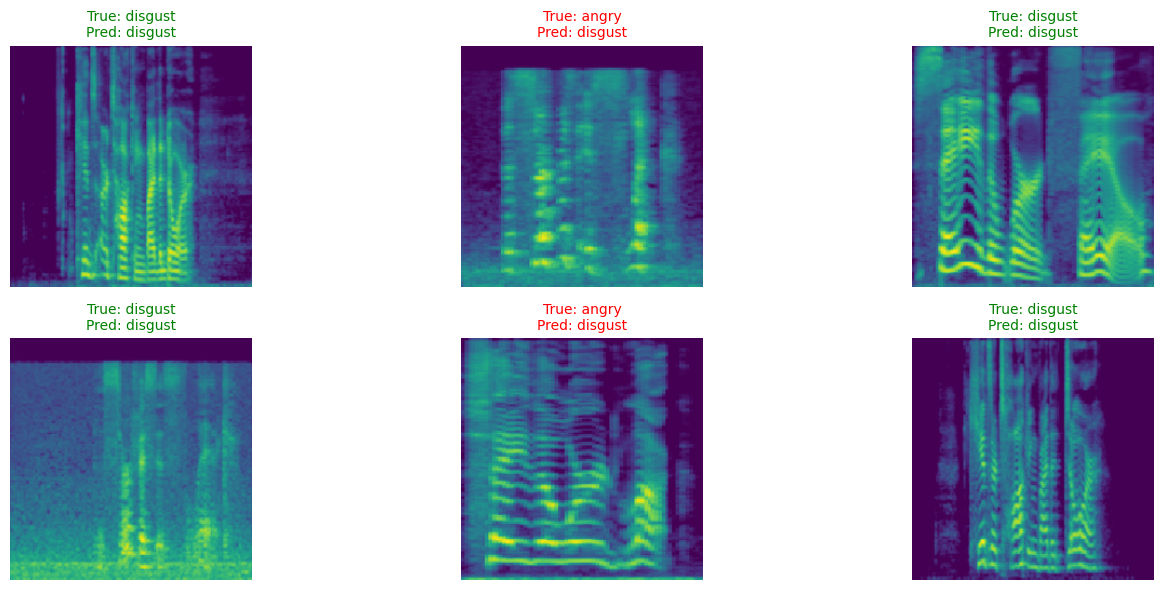

In [56]:
predict_random_samples(final_model, val_ds, class_names, num_samples=6)


In [49]:
def evaluate_random_sample_accuracy(model, dataset, class_names, num_samples=100):
    import random
    correct = 0
    total = 0

    images = []
    labels = []
    for img_batch, label_batch in dataset:
        images.extend(img_batch.numpy())
        labels.extend(label_batch.numpy())

    indices = random.sample(range(len(images)), min(num_samples, len(images)))
    
    for i in indices:
        img = images[i]
        
        # If grayscale, convert to RGB
        if img.shape[-1] == 1:
            img = np.repeat(img, 3, axis=-1)
        
        # Normalize
        img = np.expand_dims(img, axis=0).astype("float32") / 255.0
        
        true_label = labels[i]
        pred = np.argmax(model.predict(img), axis=1)[0]
        
        if pred == true_label:
            correct += 1
        total += 1

    accuracy = correct / total
    print(f"✅ Accuracy on {total} Random Validation Samples: {accuracy * 100:.2f}%")


In [50]:
def evaluate_random_sample_accuracy(model, dataset, class_names, num_samples=100):
    import random
    import numpy as np

    # Unbatch dataset and collect all images and labels
    unbatched_ds = dataset.unbatch()
    images = []
    labels = []

    for img, label in unbatched_ds.take(1000):  # take enough to sample from
        images.append(img.numpy())
        labels.append(label.numpy())

    # If fewer images than requested
    if len(images) < num_samples:
        num_samples = len(images)

    # Sample random indices
    indices = random.sample(range(len(images)), num_samples)

    correct = 0
    for i in indices:
        img = images[i]
        label = labels[i]

        # Convert grayscale to RGB if needed
        if img.shape[-1] == 1:
            img = np.repeat(img, 3, axis=-1)

        # Normalize if needed (rescale to 0–1)
        img = img.astype('float32') / 255.0

        # Add batch dimension
        img = np.expand_dims(img, axis=0)

        pred = np.argmax(model.predict(img, verbose=0), axis=1)[0]
        if pred == label:
            correct += 1

    accuracy = correct / num_samples
    print(f"✅ Accuracy on {num_samples} Random Validation Samples: {accuracy * 100:.2f}%")


In [51]:
evaluate_random_sample_accuracy(final_model, val_ds, class_names, num_samples=100)


✅ Accuracy on 100 Random Validation Samples: 54.00%
